In [1]:
import os
import pickle
import warnings
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import preprocessing
from pydub import AudioSegment

wavFile="C:/Users/User/Desktop/diploma/voice-patrol/backend/testcall.wav"


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
segLen,frameRate,numMix = 3,50,128

In [3]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [4]:
wavData,_ = librosa.load(wavFile,sr=16000)
%time vad=VoiceActivityDetection(wavData,frameRate)

CPU times: total: 93.8 ms
Wall time: 96.3 ms


C:\Users\User\AppData\Local\Temp\ipykernel_13612\566902385.py:3: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ste = librosa.feature.rms(wavData,hop_length=int(16000/frameRate)).T


In [5]:
mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:];

C:\Users\User\AppData\Local\Temp\ipykernel_13612\3933388463.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T


In [6]:
n_components = np.arange(1, 25)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

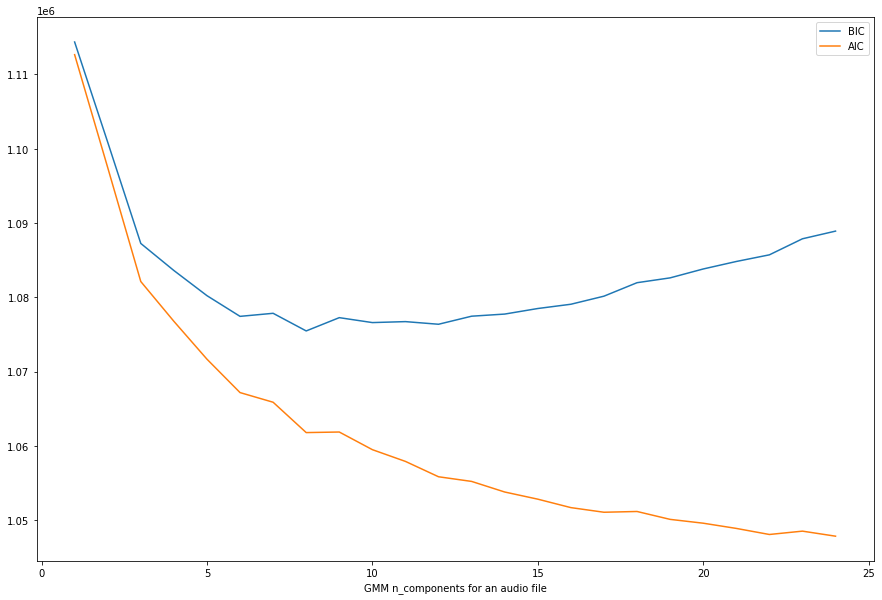

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

In [8]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")

    return np.asarray(segLikes)

In [9]:
clusterset = trainGMM(wavFile, frameRate, segLen, vad, numMix)

C:\Users\User\AppData\Local\Temp\ipykernel_13612\4059950651.py:3: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T


Training GMM..
Training Done


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = normalize(X_scaled)

In [11]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_normalized)

In [12]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [13]:
frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])

In [14]:


def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
    countSegments=0
    
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal

In [15]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, wavFile)

In [16]:
spkdf["TimeSeconds"]=spkdf.EndTime-spkdf.StartTime

In [17]:
spkdf

,Audio,SpeakerLabel,StartTime,EndTime,TimeSeconds
0,testcall.wav,Speaker 1,1.30,5.48,4.18
1,testcall.wav,Speaker 0,5.48,26.20,20.72
2,testcall.wav,Speaker 1,26.20,33.64,7.44
3,testcall.wav,Speaker 0,33.64,117.66,84.02
4,testcall.wav,Speaker 1,117.66,120.92,3.26
5,testcall.wav,Speaker 0,120.92,123.96,3.04
6,testcall.wav,Speaker 1,123.96,127.90,3.94
7,testcall.wav,Speaker 0,127.90,141.50,13.60
8,testcall.wav,Speaker 1,141.50,145.14,3.64
9,testcall.wav,Speaker 0,145.14,166.16,21.02


In [18]:
audioFileName = spkdf['Audio'][0]

In [19]:
for i in range(np.size(spkdf['Audio'])):
    newAudio = AudioSegment.from_wav(wavFile)
    newAudio = newAudio[spkdf['StartTime'][i]*1000:spkdf['EndTime'][i]*1000]
    newAudio.export(str(i)+'_'+audioFileName, format="wav") #Exports to a wav file in the current path.